# Training a ML force field (Energies of conformers)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pymatviz.parity import density_scatter_with_hist
from rdkit import Chem
from rdkit.Chem import AllChem, PyMol
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

## Helpers to generate the training data

In [2]:
def gen_conformers(mol, numConfs=10_000, maxAttempts=1000, pruneRmsThresh=0.2, useExpTorsionAnglePrefs=True, useBasicKnowledge=True, enforceChirality=True):
    ids = AllChem.EmbedMultipleConfs(mol, numConfs=numConfs, maxAttempts=maxAttempts, pruneRmsThresh=pruneRmsThresh, useExpTorsionAnglePrefs=useExpTorsionAnglePrefs, useBasicKnowledge=useBasicKnowledge, enforceChirality=enforceChirality, numThreads=0)
    return list(ids)

In [14]:
def calc_energy(mol, conformer_id, iterations=0):
	ff = AllChem.MMFFGetMoleculeForceField(mol, AllChem.MMFFGetMoleculeProperties(mol), confId=conformer_id)
	ff.Initialize()
	ff.CalcEnergy()
	results = {}
	if iterations > 0:
		results["converged"] = ff.Minimize(maxIts=iterations)
	results["energy_abs"] = ff.CalcEnergy()
	return results

In [3]:
mol = Chem.AddHs(Chem.MolFromSmiles('CC(CCC)CC(C)(CCCC)O'))

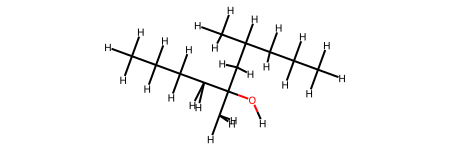

In [4]:
mol

In [5]:
conformer_ids = gen_conformers(mol)

In [6]:
v= PyMol.MolViewer()
v.DeleteAll()
for cid in conformer_ids[:50]: 
    v.ShowMol(mol,confId=cid,name='Conf-%d'%cid,showOnly=False)

In [7]:
v.server.do('set grid_mode, on')

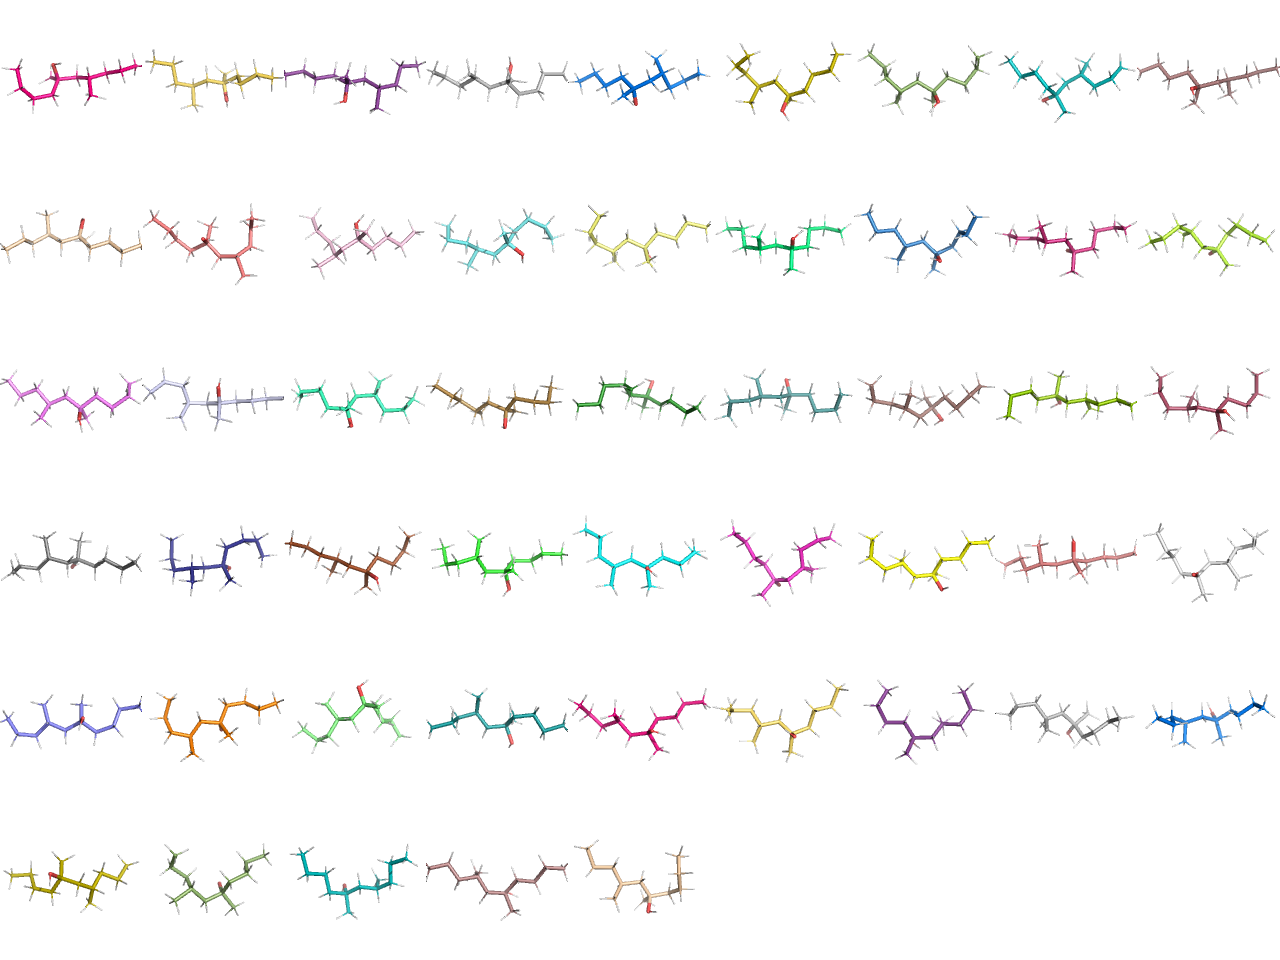

In [8]:
v.server.do('ray')
v.GetPNG()

## Generate the training data

In [9]:
coordinate_names = sum([[f'x_{n}',f'y_{n}', f'z_{n}'] for n in range(mol.GetNumAtoms())], []) # helper to define the column names

In [15]:
data = []
for conformer_id in conformer_ids:
    energy = calc_energy(mol, conformer_id)['energy_abs']
    positions = mol.GetConformer(conformer_id).GetPositions().flatten()
    position_dict = dict(zip(coordinate_names, positions))
    position_dict['energy'] = energy
                         
    data.append(position_dict)

In [16]:
data = pd.DataFrame(data).sample(len(data))

In [17]:
data

,x_0,y_0,z_0,x_1,y_1,z_1,x_2,y_2,z_2,x_3,...,x_36,y_36,z_36,x_37,y_37,z_37,x_38,y_38,z_38,energy
1363,-1.982185,1.817948,1.106838,-1.196066,0.806065,0.253684,-2.262617,-0.113504,-0.321372,-3.194348,...,3.769427,-1.367124,-0.662723,4.991946,-0.800345,0.487904,0.250885,-2.862363,0.249038,56.710044
1196,1.911422,2.151933,-1.194688,1.723507,0.620815,-0.728758,2.861602,0.454208,0.171044,3.118432,...,-4.372916,-1.305997,-0.414745,-4.504489,-0.481779,1.215161,-0.855136,-1.286874,1.990118,74.343358
1995,-2.710756,-1.839904,-0.279376,-1.661044,-0.727075,-0.335984,-2.159353,0.537553,0.243815,-3.362669,...,4.640549,1.986707,0.148566,5.191428,1.223396,-1.403452,1.418696,-1.680316,1.822156,60.559404
900,2.300367,-0.970931,1.030650,1.477156,-0.352258,-0.098382,1.191417,1.092264,0.077711,2.530027,...,-1.463497,2.343170,0.510569,-2.235494,1.666174,1.999365,-0.113572,-2.044338,2.141312,59.766162
1102,-2.474067,0.672591,1.824510,-1.398833,0.195035,0.828351,-2.099766,-0.280642,-0.395083,-3.040824,...,4.362757,-2.603090,-0.772449,2.618765,-2.061409,-0.569794,1.842787,2.762605,-0.899394,70.995808
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1593,-1.757163,2.155939,0.970426,-1.226022,1.046697,0.053440,-2.189159,0.670283,-0.982063,-3.539446,...,5.601245,0.669586,-0.858437,4.610993,0.870480,0.609343,-0.385994,-2.258857,-1.342279,54.912536
2529,-2.075464,-1.958804,-0.541091,-1.698656,-0.781492,0.282750,-2.683911,0.328240,-0.109316,-2.472349,...,4.594843,1.615780,-0.832410,3.550153,1.286829,-2.249587,0.358361,-1.066826,2.540109,61.683839
2146,-3.048309,1.742704,0.386882,-1.761237,0.914498,0.674321,-2.079656,-0.388206,-0.075523,-3.333090,...,5.154742,-1.747844,-1.104080,5.078106,-1.028640,0.520432,1.125060,2.481642,1.496999,58.811741
1964,-1.607334,-0.963071,-1.666311,-1.528423,0.413364,-0.990780,-2.841464,1.100836,-0.988446,-3.988422,...,5.189583,-0.548014,-0.685702,3.473254,-0.831312,-1.114986,1.253396,-1.308632,-1.451277,86.206343


(array([3.770e+02, 1.689e+03, 8.890e+02, 2.410e+02, 3.100e+01, 2.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00]),
 array([ 36.57191284,  49.90016261,  63.22841237,  76.55666214,
         89.88491191, 103.21316168, 116.54141145, 129.86966121,
        143.19791098, 156.52616075, 169.85441052]),
 <BarContainer object of 10 artists>)

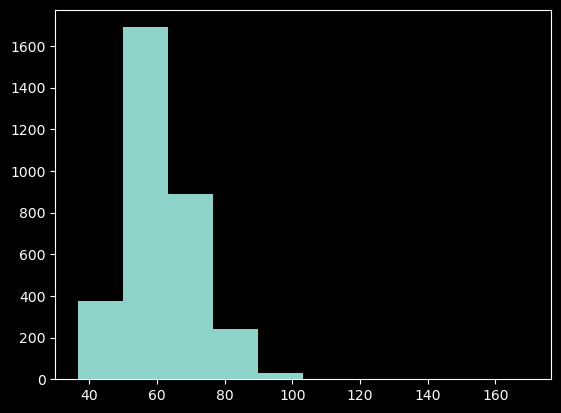

In [18]:
plt.hist(data['energy'])

## Build a model

In [17]:
positions = 
energies = 

In [18]:
len(positions)

3231

In [33]:
train_points = 300

Let's use a gradient boosting regressor to predict the energies of the conformers.
`HistGradientBoostingRegressor` is an efficient `sklearn` implementation.

Note that in practice you would still tune the hyperparameters of the model.

HistGradientBoostingRegressor()

## Test the model

In [40]:
train_predictions = 

<AxesSubplot:xlabel='Actual', ylabel='Predicted'>

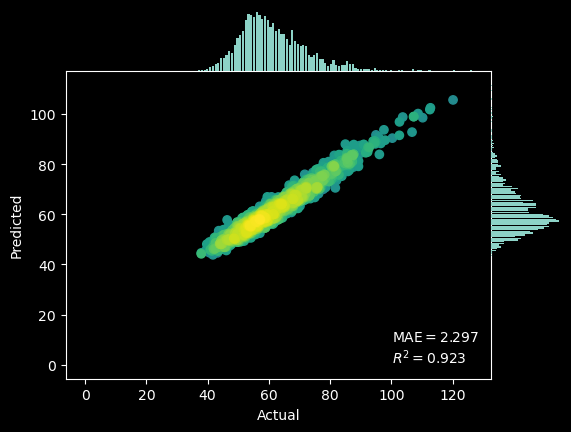

In [41]:
density_scatter_with_hist(train_energies.values, train_predictions)

In [38]:
test_predictions = 

<AxesSubplot:xlabel='Actual', ylabel='Predicted'>

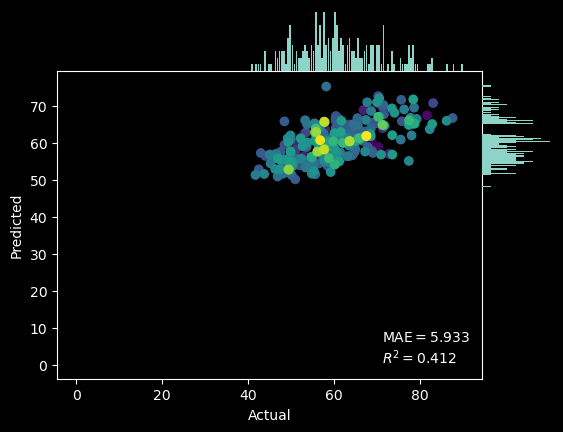

In [39]:
density_scatter_with_hist(test_energies.values, test_predictions)

## Change the positions

In [43]:
translated_positions = 
translated_predictions = 

<AxesSubplot:xlabel='Actual', ylabel='Predicted'>

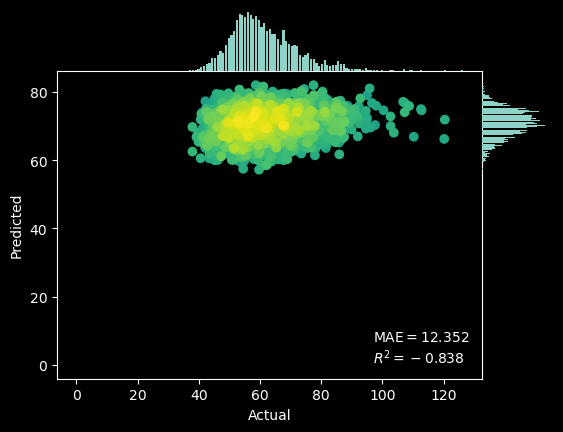

In [44]:
density_scatter_with_hist(train_energies.values, translated_predictions)